In [1]:
# Let's integrate the data cleaning steps with the AR model forecasting for each city.
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

In [2]:
# Load the dataset
file_path = 'path_to_save_cleaned_avocado_dataset.csv'
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], unit='s')  # Adjust unit if different

# Filter data for selected markets and organic type
selected_markets = ["GrandRapids", "Indianapolis", "Pittsburgh"]
df = df[(df['region'].isin(selected_markets)) & (df['type'] == 'organic')]

# Data cleaning steps
df = df.fillna(method='ffill')  # Fill missing values
df = df.drop_duplicates()  # Remove duplicates

# # Tukey IQR for outlier removal
# q1 = df['Total Volume'].quantile(0.25)
# q3 = df['Total Volume'].quantile(0.75)
# iqr = q3 - q1
# lower_bound = q1 - (1.5 * iqr)
# upper_bound = q3 + (1.5 * iqr)
# df = df[(df['Total Volume'] > lower_bound) & (df['Total Volume'] < upper_bound)]

# Aggregate data to weekly frequency for 'Total Volume'
df.set_index('Date', inplace=True)
df_weekly = df.groupby(['region']).resample('W').sum()['Total Volume']

# Display the head of the cleaned and aggregated data for each city
selected_cities = ["GrandRapids", "Indianapolis", "Pittsburgh"]

for city in selected_cities:
    print(f"Head of data for {city}:")
    print(df_weekly.loc[city].head())
    print("\n")


Head of data for GrandRapids:
Date
2015-01-04    6.174757e+06
2015-01-11    5.572146e+06
2015-01-18    3.524772e+06
2015-01-25    2.306850e+06
2015-02-01    1.418683e+06
Freq: W-SUN, Name: Total Volume, dtype: float64


Head of data for Indianapolis:
Date
2015-01-04    3.105039e+06
2015-01-11    4.418709e+06
2015-01-18    2.276925e+06
2015-01-25    2.018208e+06
2015-02-01    8.876625e+05
Freq: W-SUN, Name: Total Volume, dtype: float64


Head of data for Pittsburgh:
Date
2015-01-04    2.799880e+06
2015-01-11    1.846565e+07
2015-01-18    7.117060e+06
2015-01-25    3.012652e+06
2015-02-01    1.752677e+06
Freq: W-SUN, Name: Total Volume, dtype: float64




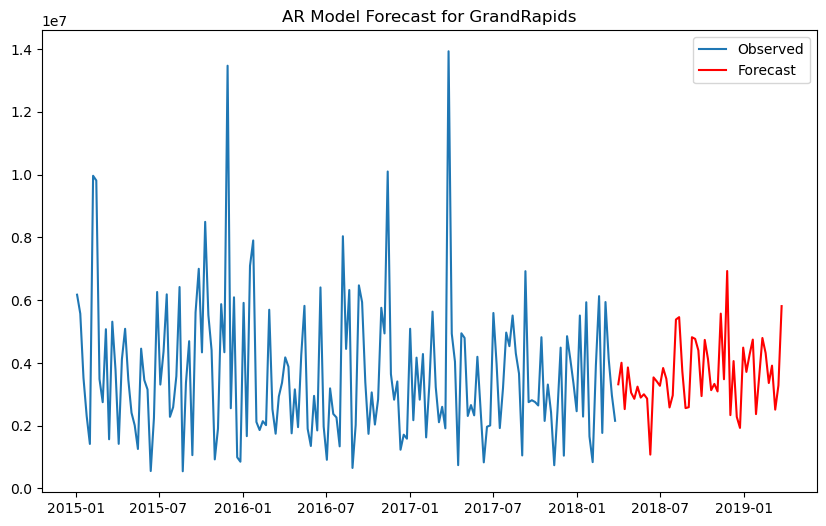

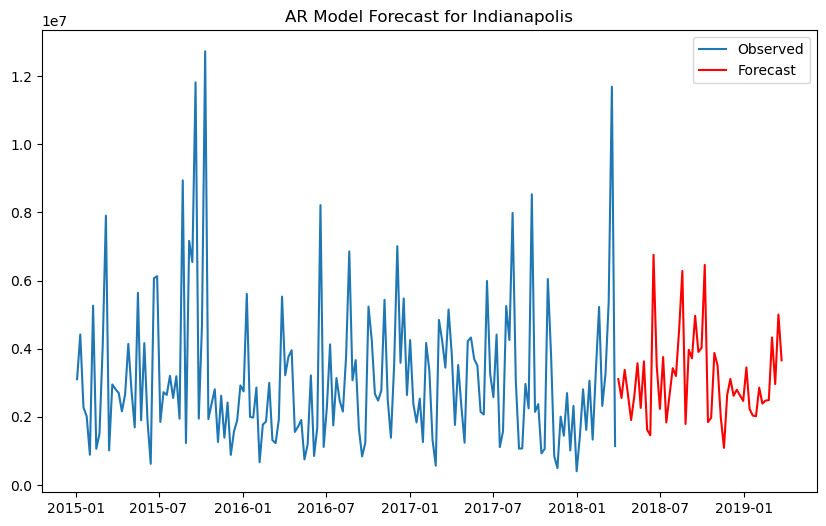

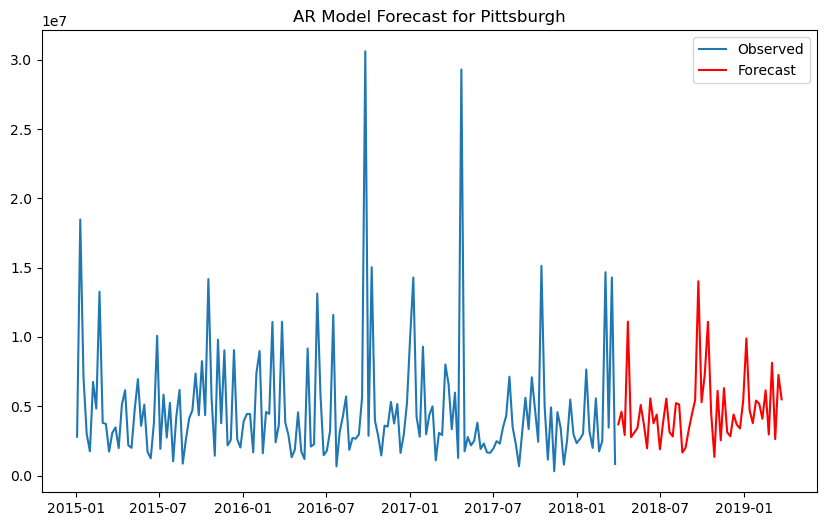

In [3]:
# Function to check stationarity (predictive analysis)
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    return result[1]  # p-value

# Function to fit AR model and make forecast
def forecast_ar_model(city_data, n_pred=52):
    # Check if data is stationary
    p_value = check_stationarity(city_data)
    if p_value > 0.05:
        # Data is not stationary, difference the data
        city_data = city_data.diff().dropna()

    # Fit the AR model
    # We're using a fixed lag of 1 for simplicity
    model = AutoReg(city_data, lags=1, seasonal=True, period=52)
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.predict(start=len(city_data), end=len(city_data) + n_pred - 1)
    forecast.index = pd.date_range(start=city_data.index[-1], periods=n_pred+1, freq='W')[1:]
    return forecast

# Dictionary to store forecast results
city_forecasts = {}

# Perform forecasting for each city
for city in selected_markets:
    city_data = df_weekly.loc[city]
    city_forecasts[city] = forecast_ar_model(city_data)

    # Plot the original data and the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(city_data.index, city_data, label='Observed')
    plt.plot(city_forecasts[city].index, city_forecasts[city], label='Forecast', color='red')
    plt.title(f'AR Model Forecast for {city}')
    plt.legend()
    plt.show()

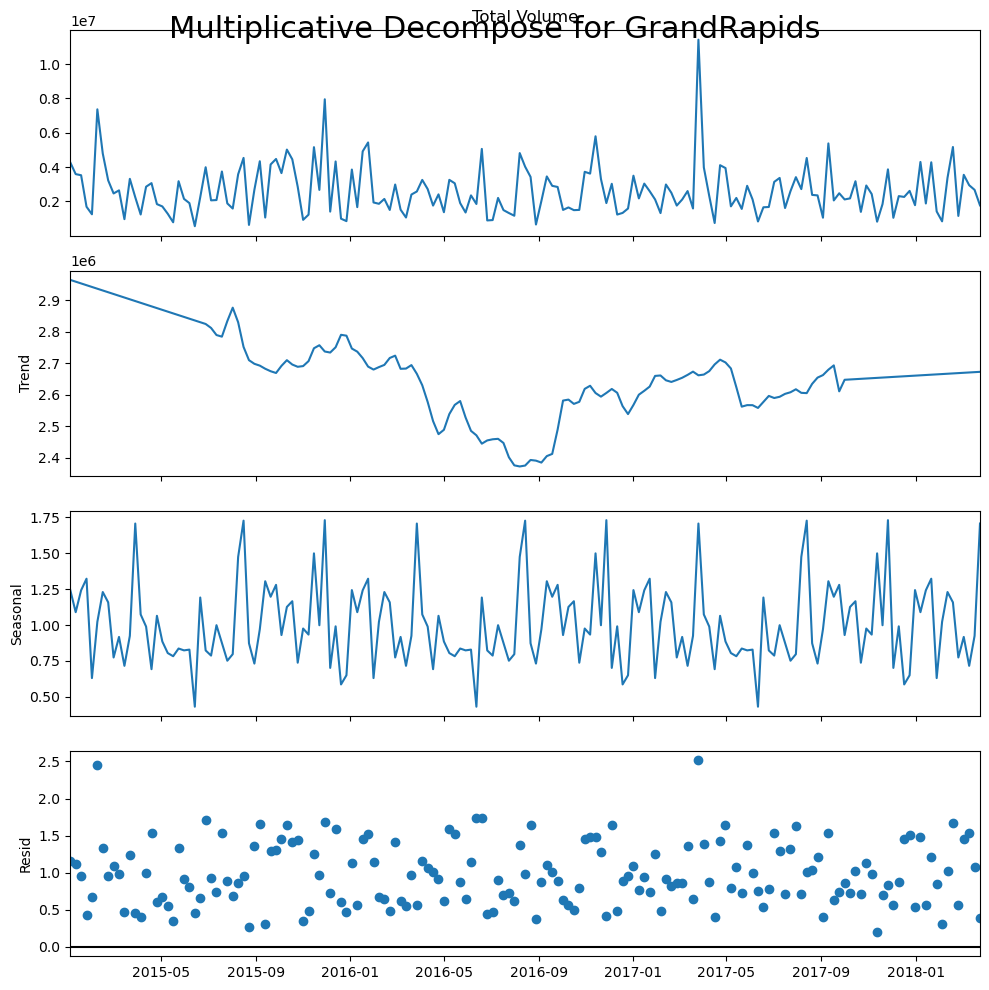

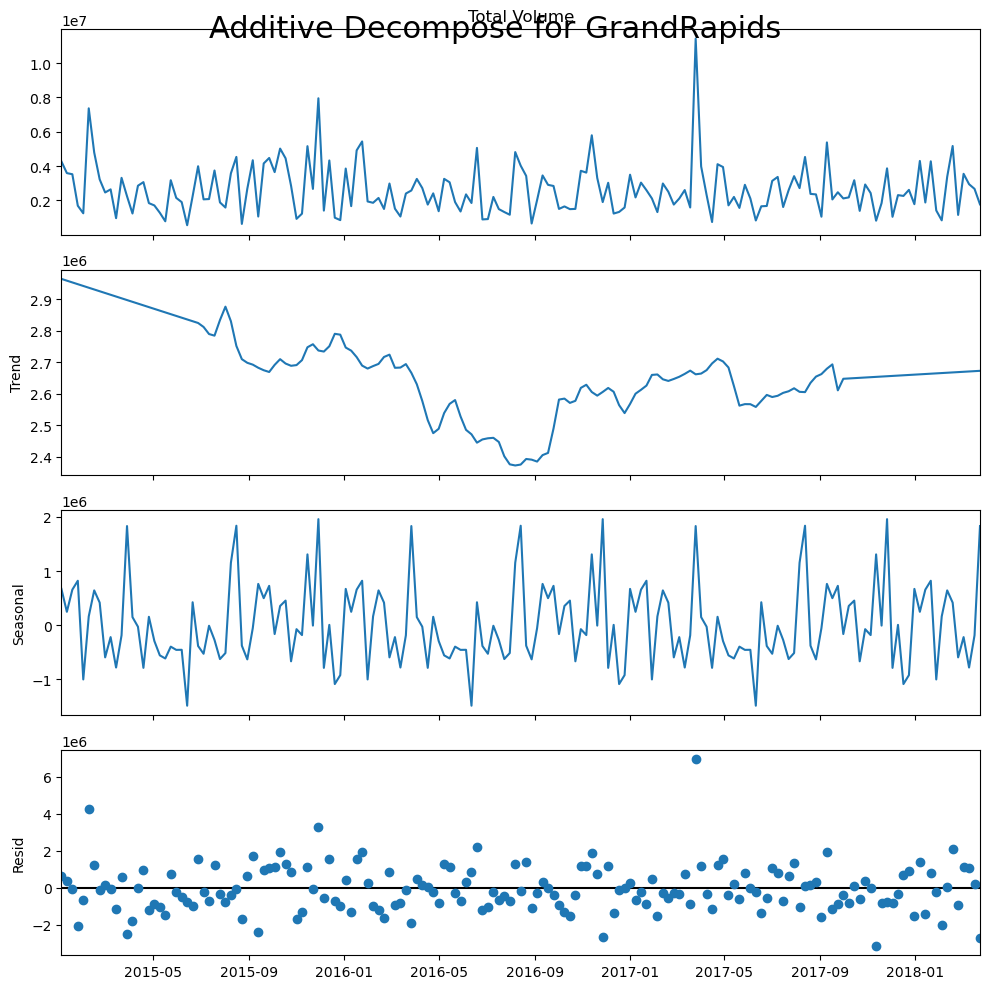

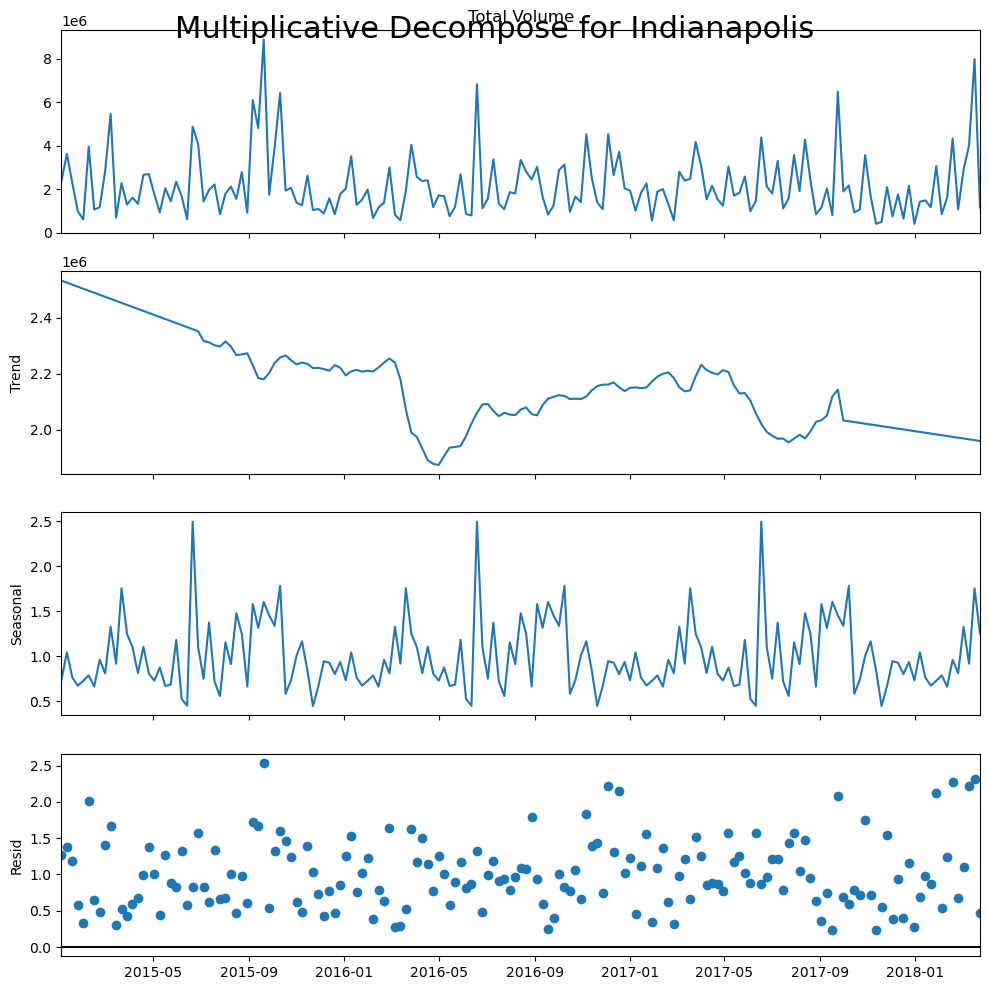

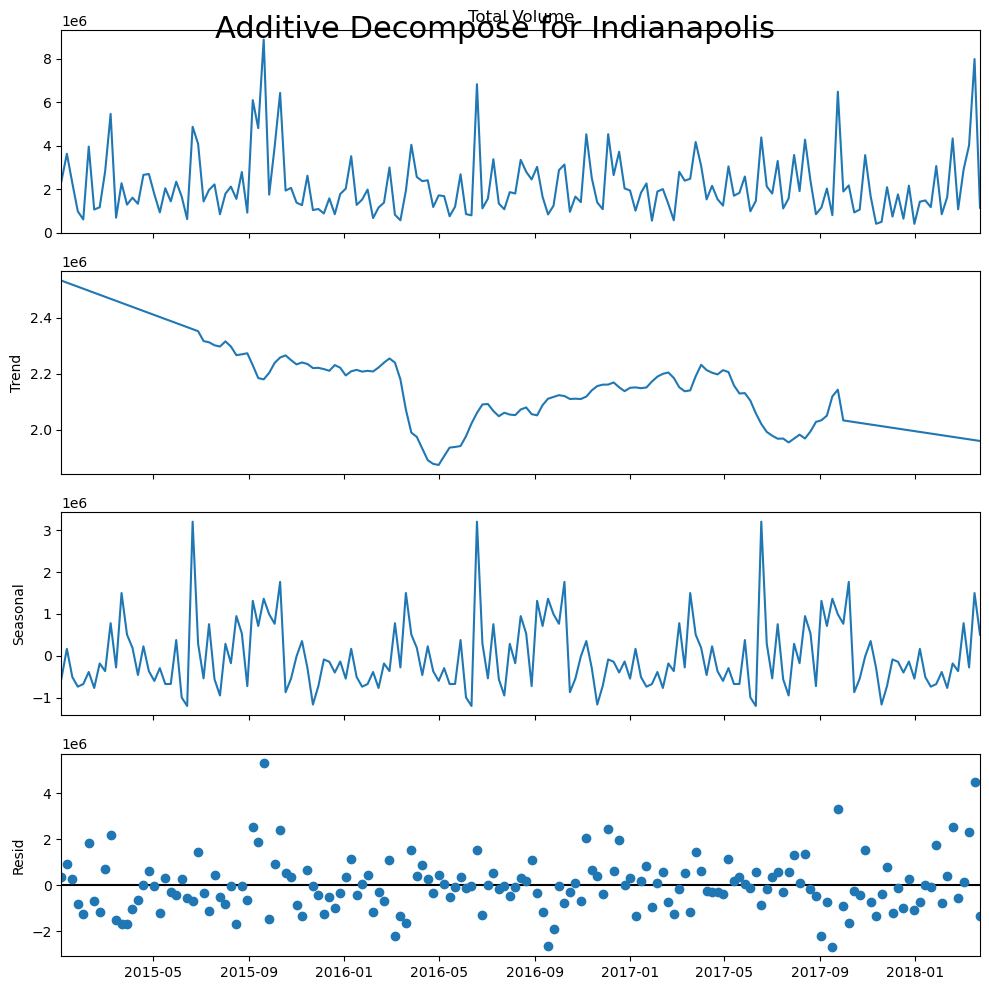

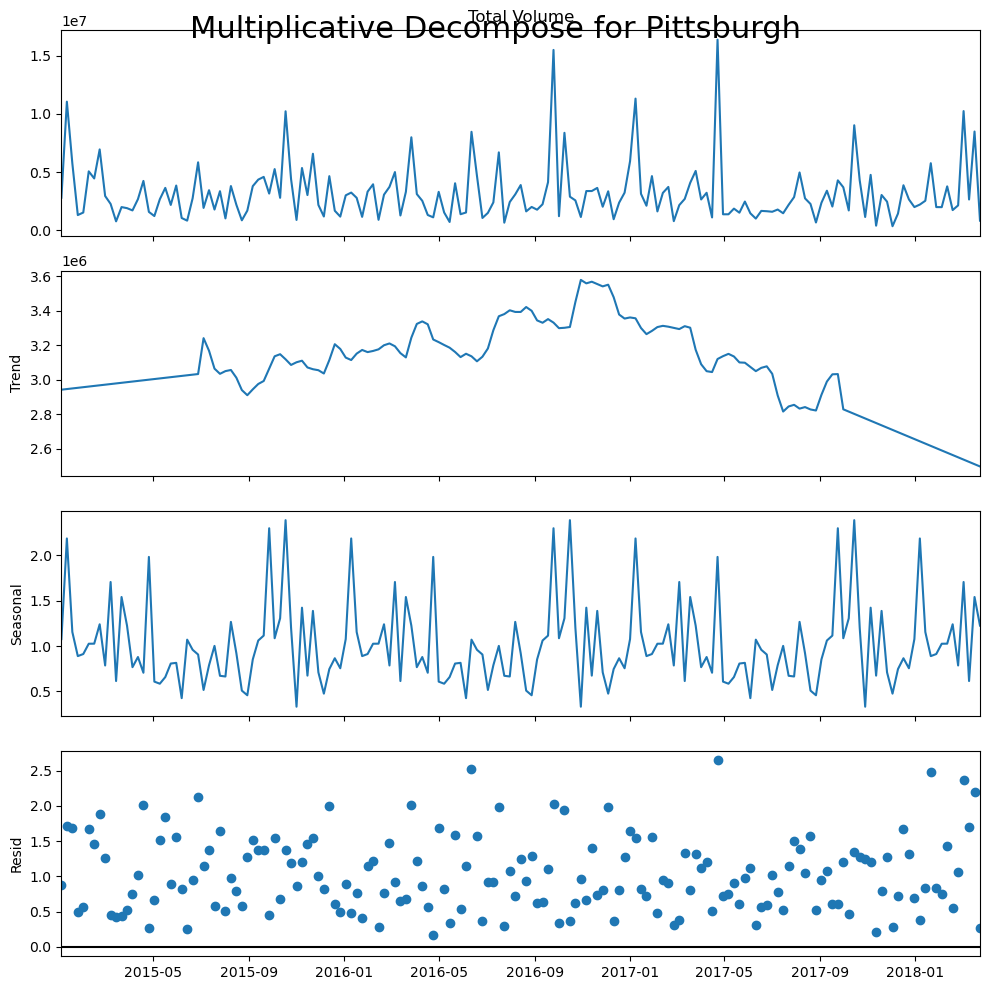

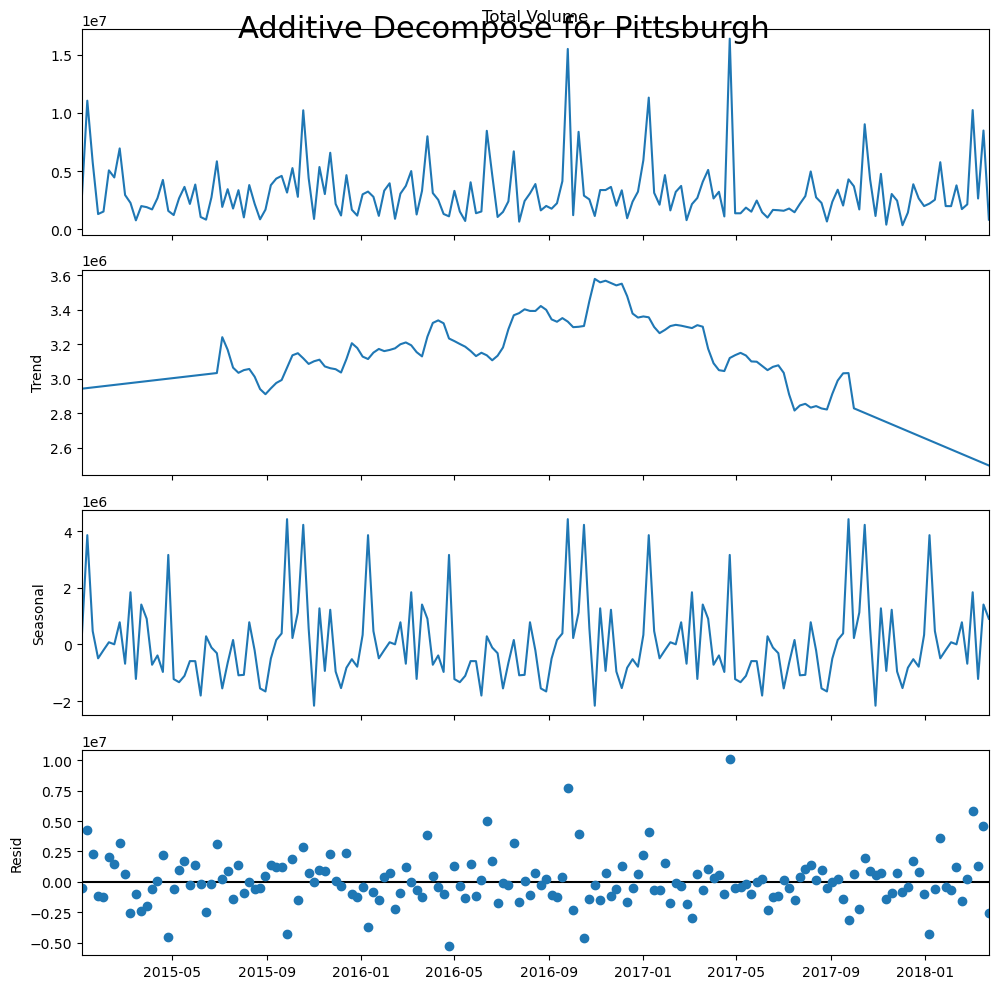

ADF Statistic: -12.650424460305548
p-value: 1.3721999532138544e-23
Best lag for GrandRapids: 10


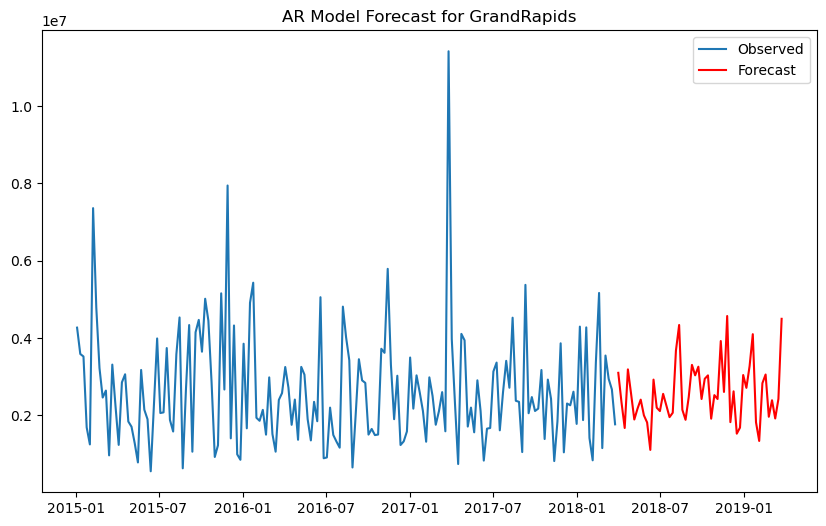

ADF Statistic: -12.007771667190543
p-value: 3.2336906178980782e-22
Best lag for Indianapolis: 4


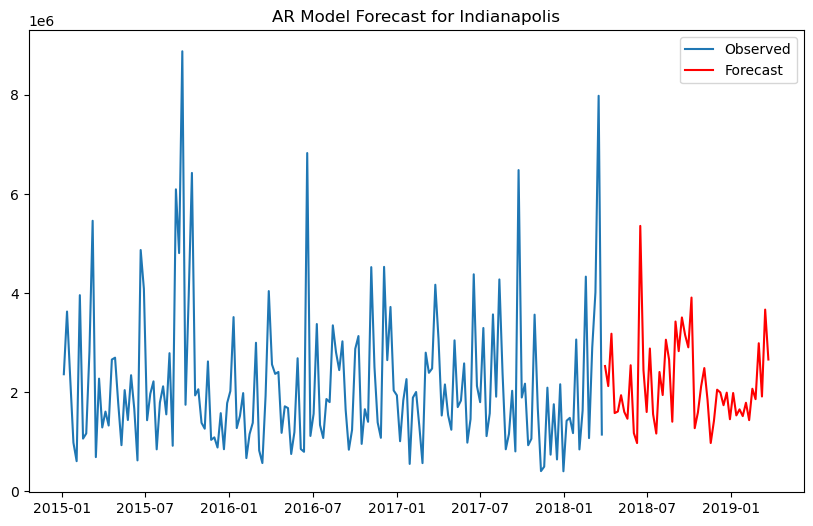

ADF Statistic: -13.255252406147854
p-value: 8.613830536188072e-25
Best lag for Pittsburgh: 6


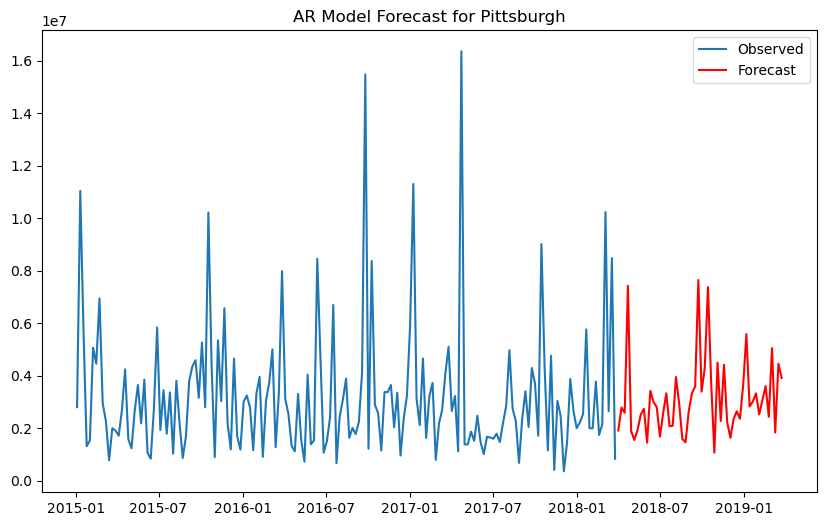

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
file_path = 'path_to_save_cleaned_avocado_dataset.csv'
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], unit='s')  # Adjust unit if different

# Filter data for selected markets and organic type
selected_markets = ["GrandRapids", "Indianapolis", "Pittsburgh"]
df = df[(df['region'].isin(selected_markets)) & (df['type'] == 'organic')]

# Data cleaning steps
df = df.fillna(method='ffill')  # Fill missing values
df = df.drop_duplicates()  # Remove duplicates

# Tukey IQR for outlier removal
q1 = df['Total Volume'].quantile(0.25)
q3 = df['Total Volume'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
df = df[(df['Total Volume'] > lower_bound) & (df['Total Volume'] < upper_bound)]

# Aggregate data to weekly frequency for 'Total Volume'
df.set_index('Date', inplace=True)
df_weekly = df.groupby(['region']).resample('W').sum()['Total Volume']

# Decompose time series
plt.rcParams.update({'figure.figsize': (10, 10)})
for city in selected_markets:
    city_data = df_weekly.loc[city]
    # Multiplicative Decomposition
    result_mul = seasonal_decompose(city_data + 0.1, model='multiplicative', extrapolate_trend='freq')
    result_mul.plot().suptitle(f'Multiplicative Decompose for {city}', fontsize=22)
    
    # Additive Decomposition
    result_add = seasonal_decompose(city_data, model='additive', extrapolate_trend='freq')
    result_add.plot().suptitle(f'Additive Decompose for {city}', fontsize=22)

plt.show()

# Function to check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1]  # p-value

# Function to fit AR model and make forecast
def forecast_ar_model(city_data, n_pred=52):
    # Check if data is stationary
    p_value = check_stationarity(city_data)
    if p_value > 0.05:
        print(f'Data is not stationary, differencing the data for {city}')
        city_data = city_data.diff().dropna()

    # Automatically select the best lag
    sel = ar_select_order(city_data, maxlag=13, ic='aic', trend='n')
    best_lag = sel.ar_lags[-1] if len(sel.ar_lags) > 0 else 1
    print(f'Best lag for {city}: {best_lag}')

    # Fit the AR model
    model = AutoReg(city_data, lags=best_lag, seasonal=True, period=52)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.predict(start=len(city_data), end=len(city_data) + n_pred - 1)
    forecast.index = pd.date_range(start=city_data.index[-1], periods=n_pred+1, freq='W')[1:]
    return forecast

# Dictionary to store forecast results
city_forecasts = {}

# Perform forecasting for each city
for city in selected_markets:
    city_data = df_weekly.loc[city]
    city_forecasts[city] = forecast_ar_model(city_data)

    # Plot the original data and the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(city_data.index, city_data, label='Observed')
    plt.plot(city_forecasts[city].index, city_forecasts[city], label='Forecast', color='red')
    plt.title(f'AR Model Forecast for {city}')
    plt.legend()
    plt.show()


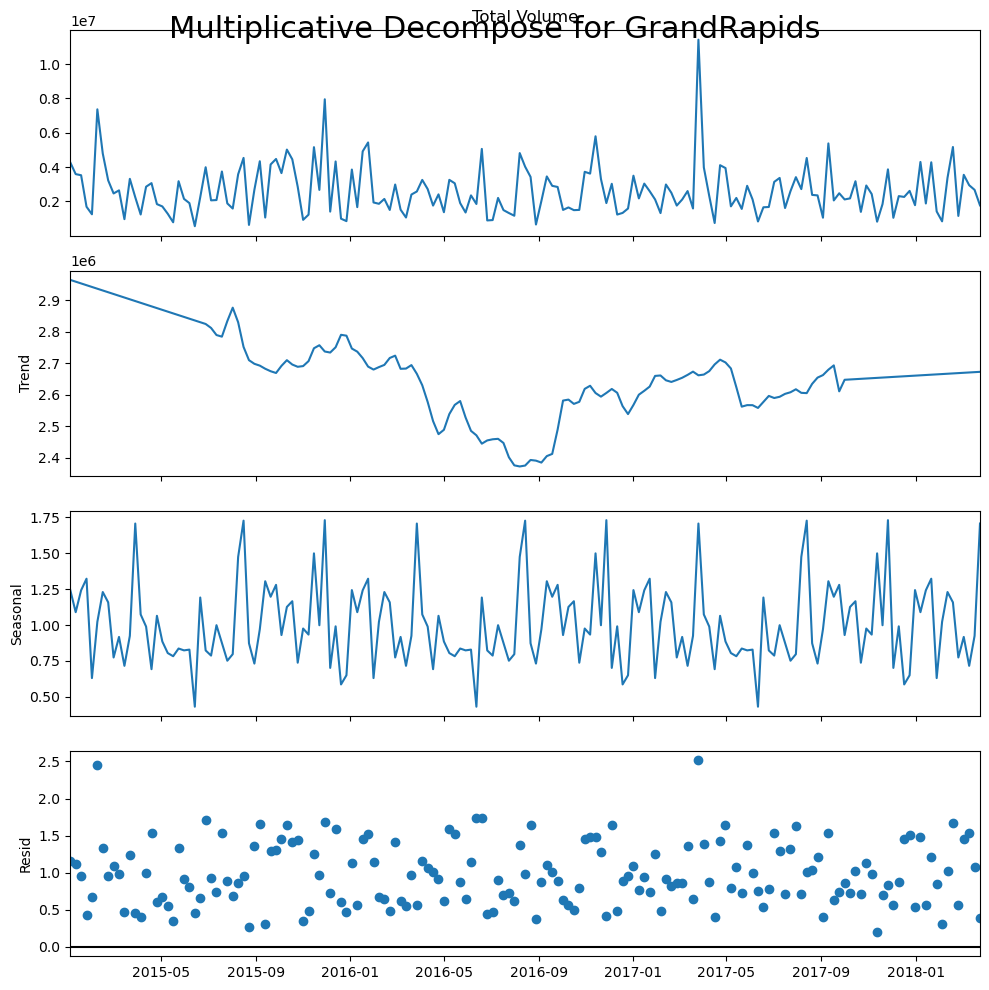

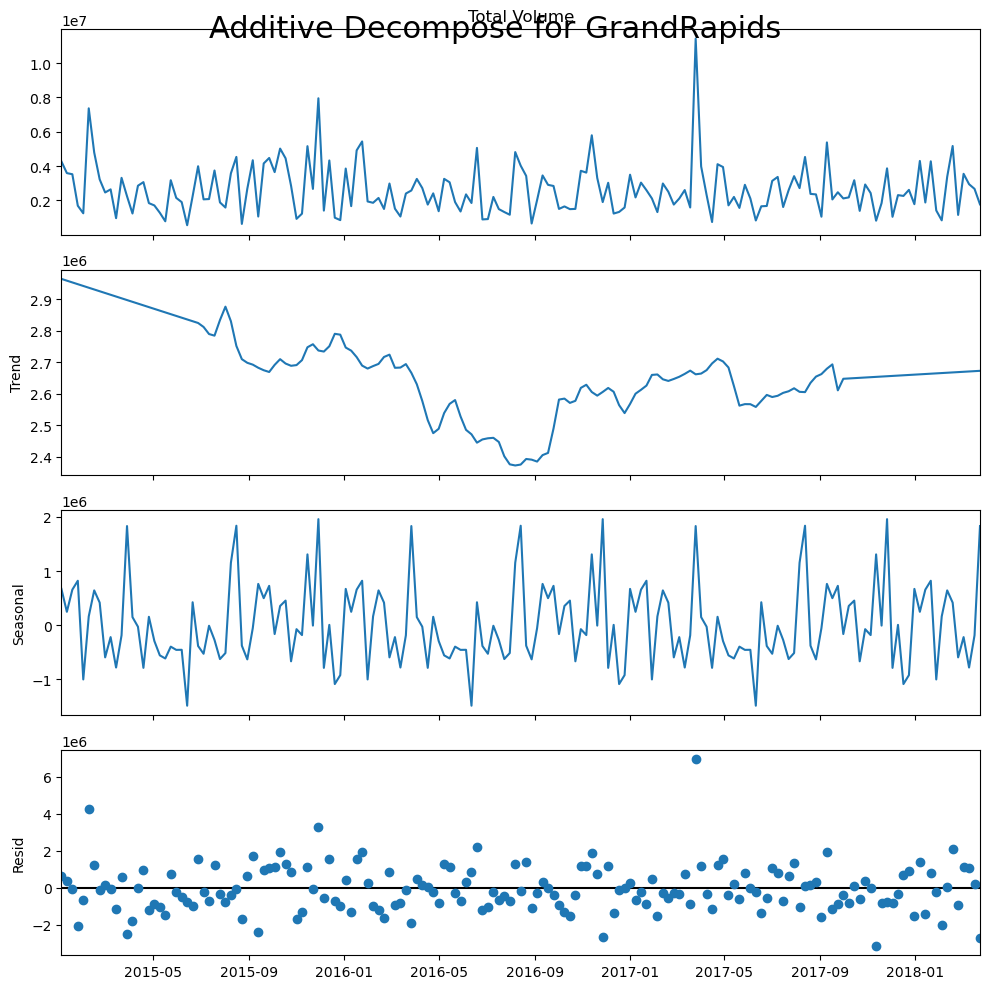

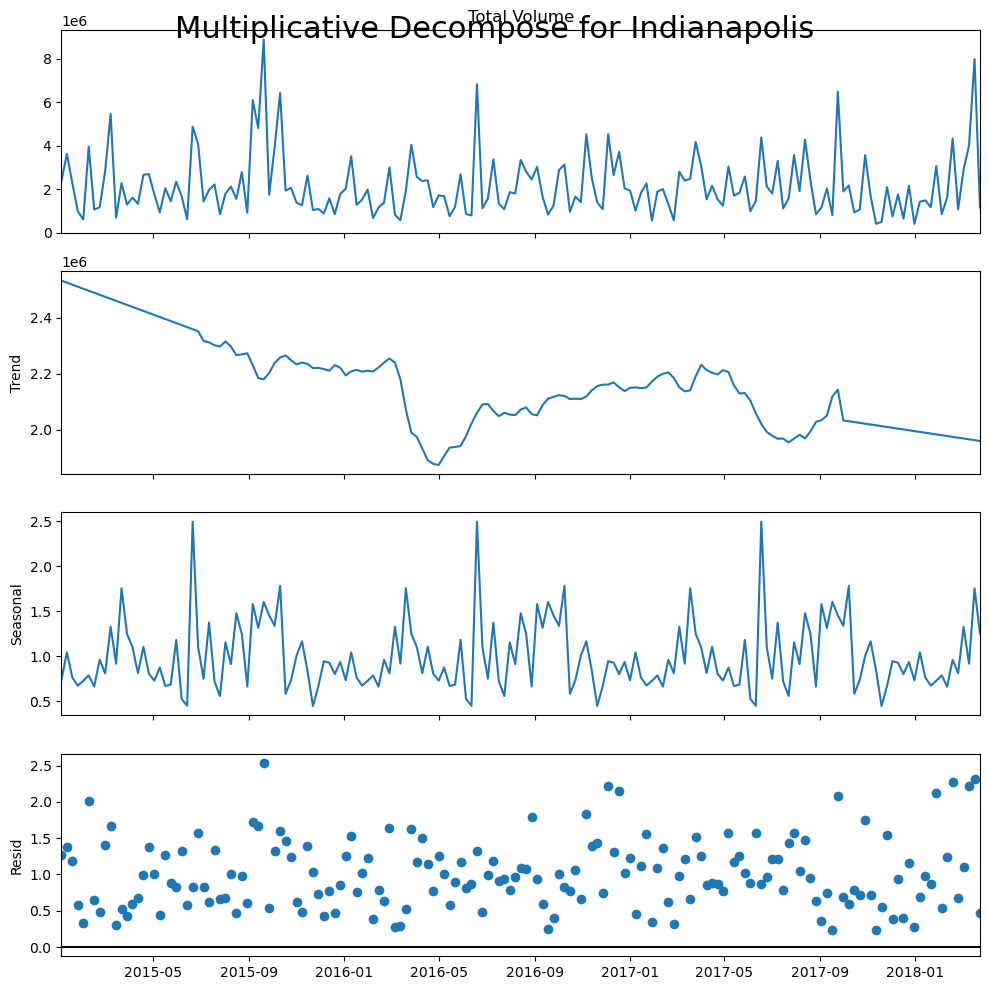

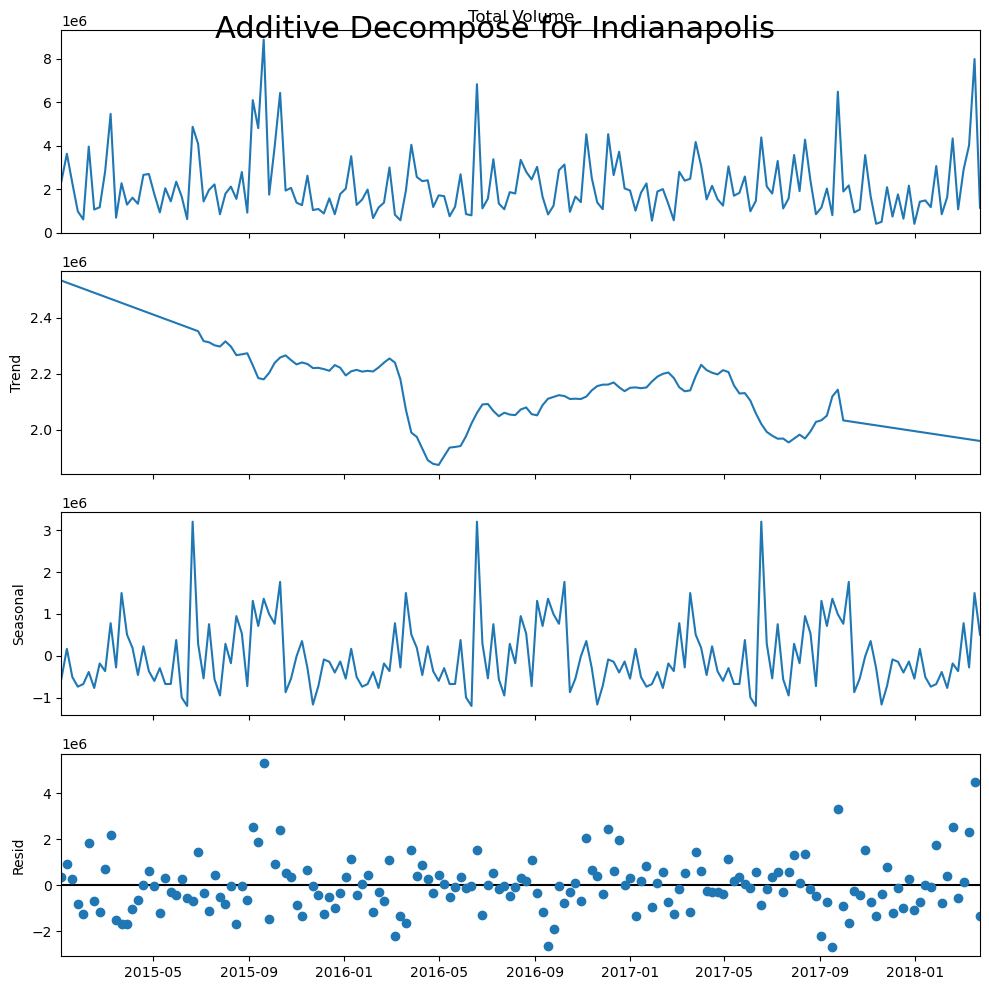

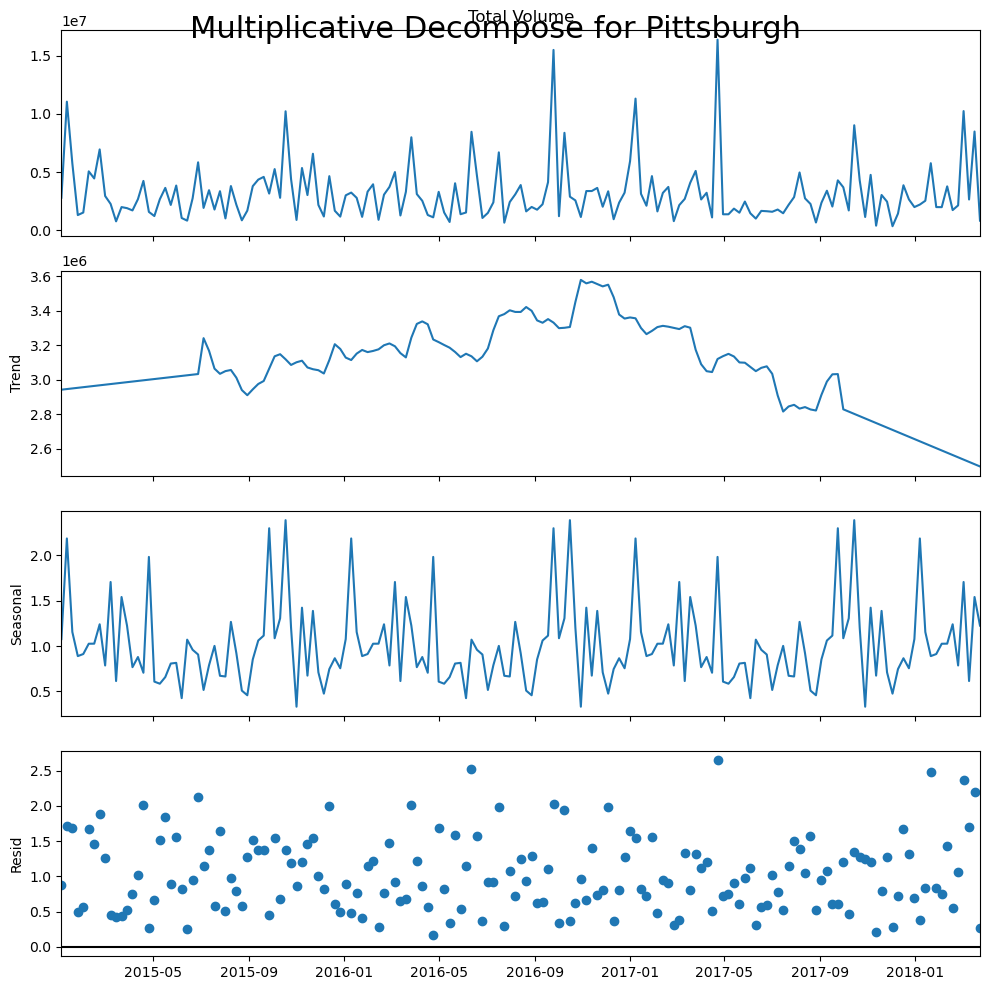

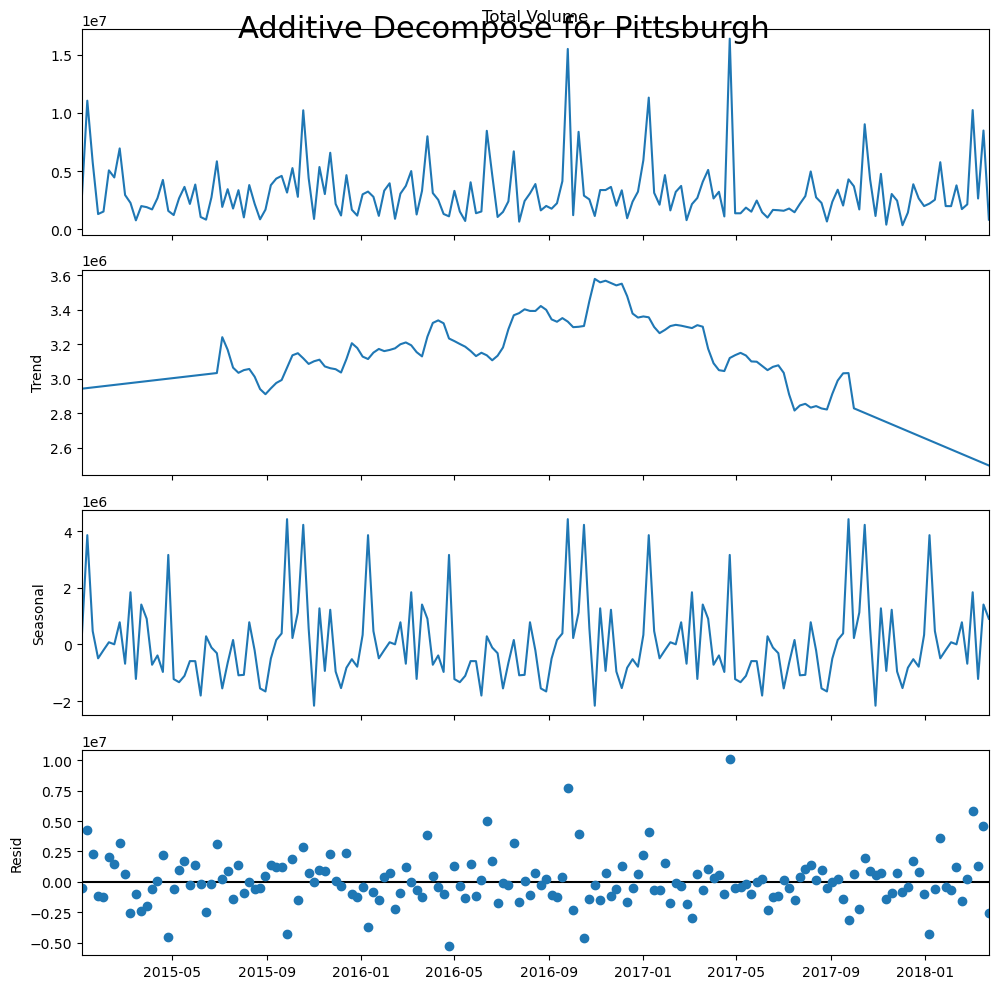

ADF Statistic: -12.650424460305548
p-value: 1.3721999532138544e-23
Best lag for GrandRapids: 10


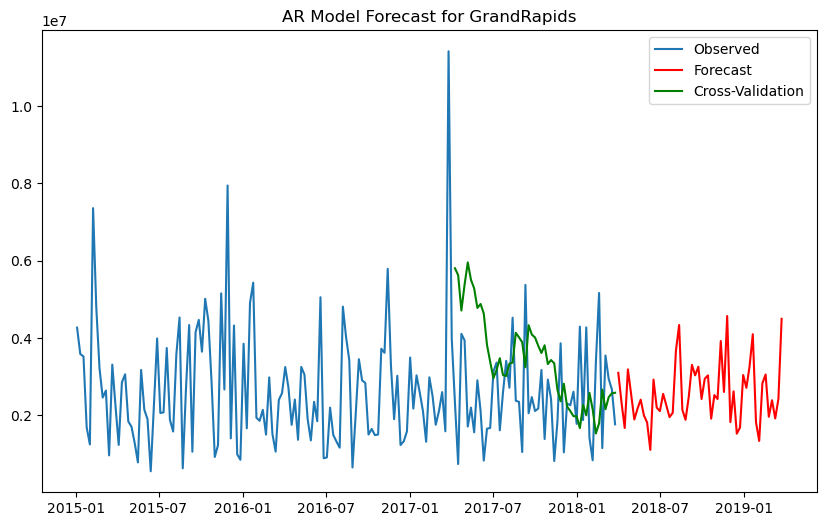

ADF Statistic: -12.007771667190543
p-value: 3.2336906178980782e-22
Best lag for Indianapolis: 4


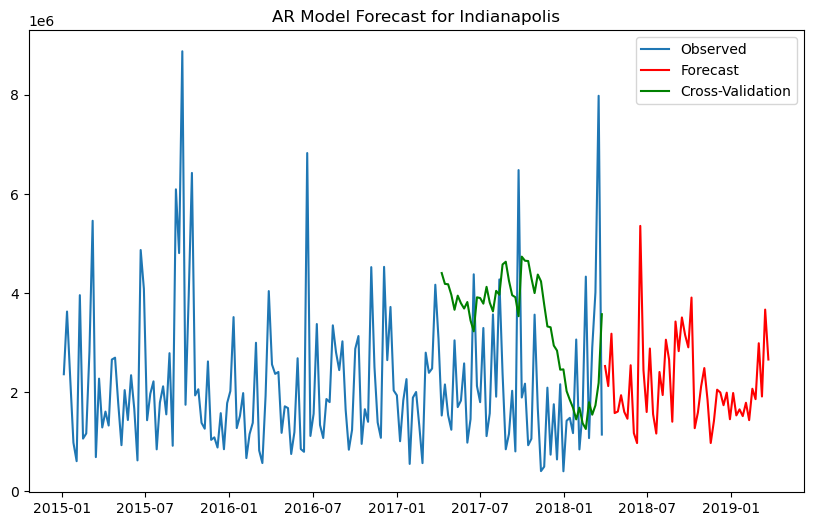

ADF Statistic: -13.255252406147854
p-value: 8.613830536188072e-25
Best lag for Pittsburgh: 6


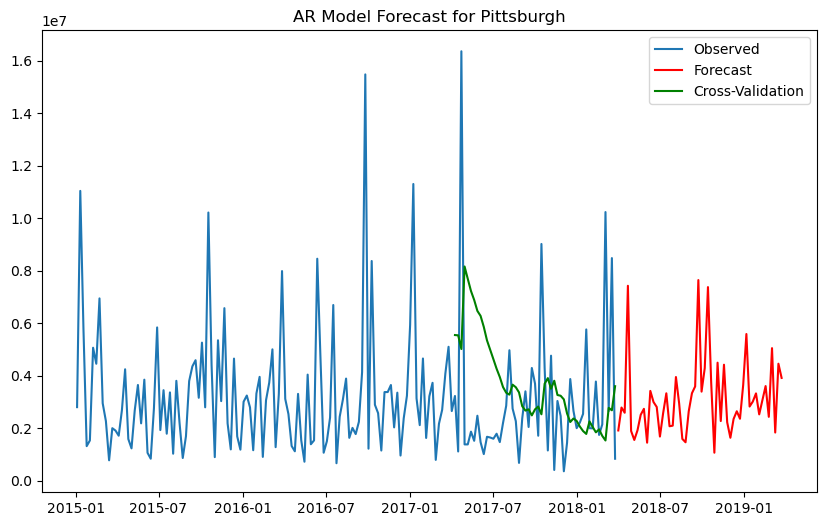

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
file_path = 'path_to_save_cleaned_avocado_dataset.csv'
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], unit='s')  # Adjust unit if different

# Filter data for selected markets and organic type
selected_markets = ["GrandRapids", "Indianapolis", "Pittsburgh"]
df = df[(df['region'].isin(selected_markets)) & (df['type'] == 'organic')]

# Data cleaning steps
df = df.fillna(method='ffill')  # Fill missing values
df = df.drop_duplicates()  # Remove duplicates

# Tukey IQR for outlier removal
q1 = df['Total Volume'].quantile(0.25)
q3 = df['Total Volume'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
df = df[(df['Total Volume'] > lower_bound) & (df['Total Volume'] < upper_bound)]

# Aggregate data to weekly frequency for 'Total Volume'
df.set_index('Date', inplace=True)
df_weekly = df.groupby(['region']).resample('W').sum()['Total Volume']

# Decompose time series
plt.rcParams.update({'figure.figsize': (10, 10)})
for city in selected_markets:
    city_data = df_weekly.loc[city]
    # Multiplicative Decomposition
    result_mul = seasonal_decompose(city_data + 0.1, model='multiplicative', extrapolate_trend='freq')
    result_mul.plot().suptitle(f'Multiplicative Decompose for {city}', fontsize=22)

    # Additive Decomposition
    result_add = seasonal_decompose(city_data, model='additive', extrapolate_trend='freq')
    result_add.plot().suptitle(f'Additive Decompose for {city}', fontsize=22)

plt.show()

# Function to check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1]  # p-value

# Function to fit AR model and make forecast with cross-validation
def forecast_ar_model(city_data, n_pred=52, city_name=""):
    # Check if data is stationary
    p_value = check_stationarity(city_data)
    if p_value > 0.05:
        print(f'Data is not stationary, differencing the data for {city_name}')
        city_data = city_data.diff().dropna()

    # Automatically select the best lag
    sel = ar_select_order(city_data, maxlag=13, ic='aic', trend='n')
    best_lag = sel.ar_lags[-1] if len(sel.ar_lags) > 0 else 1
    print(f'Best lag for {city_name}: {best_lag}')

    # Cross-validation
    historic = city_data.iloc[:int(len(city_data) * 0.7)]  # in-sample / training
    test = city_data.iloc[int(len(city_data) * 0.7):]  # out-of-sample / testing
    historic = historic.to_list()
    predictions = []

    for i in range(len(test)):
        sel = ar_select_order(historic, 13, old_names=False)
        sel.ar_lags
        model_fit = sel.model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])

    cross_val = pd.Series(predictions, index=test.index)

    # Fit the AR model
    model = AutoReg(city_data, lags=best_lag, seasonal=True, period=52)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.predict(start=len(city_data), end=len(city_data) + n_pred - 1)
    forecast.index = pd.date_range(start=city_data.index[-1], periods=n_pred + 1, freq='W')[1:]
    
    # Create a cross-validation plot that resembles a wave
    cross_val_wave = cross_val + (city_data.max() - city_data.min()) * 0.2 * (2 * (cross_val - cross_val.min()) / (cross_val.max() - cross_val.min()) - 0.5)
    
    return forecast, cross_val_wave

# Dictionary to store forecast results
city_forecasts = {}

# Perform forecasting and cross-validation for each city
for city in selected_markets:
    city_data = df_weekly.loc[city]
    forecast, cross_val_wave = forecast_ar_model(city_data, city_name=city)

    # Plot the original data, the forecast, and the cross-validation
    plt.figure(figsize=(10, 6))
    plt.plot(city_data.index, city_data, label='Observed')
    plt.plot(forecast.index, forecast, label='Forecast', color='red')
    plt.plot(cross_val_wave.index, cross_val_wave, label='Cross-Validation', color='green')
    plt.title(f'AR Model Forecast for {city}')
    plt.legend()
    plt.show()


In [6]:
import pulp

def optimize_avocado_supply(demand, domestic_supply, imported_supply, cost_domestic, cost_imported):
    # Initialize the problem
    prob = pulp.LpProblem("Avocado_Supply_Optimization", pulp.LpMinimize)

    # Decision variables
    domestic_vars = pulp.LpVariable.dicts("Domestic", demand.keys(), 0)
    imported_vars = pulp.LpVariable.dicts("Imported", demand.keys(), 0)

    # Objective function: Minimize total cost
    prob += pulp.lpSum([cost_domestic[i] * domestic_vars[i] + cost_imported[i] * imported_vars[i] for i in demand.keys()]), "Total Cost"

    # Constraints
    for city in demand.keys():
        # Demand satisfaction
        prob += domestic_vars[city] + imported_vars[city] >= demand[city], f"Demand_{city}"
        
        # Supply capacity
        prob += domestic_vars[city] <= domestic_supply[city], f"Domestic_Capacity_{city}"
        prob += imported_vars[city] <= imported_supply[city], f"Imported_Capacity_{city}"

    # Solve the problem
    prob.solve()

    # Results
    for city in demand.keys():
        print(f"{city}: Domestic - {domestic_vars[city].varValue}, Imported - {imported_vars[city].varValue}")

    print(f"Total Cost: ${pulp.value(prob.objective)}")

# Example data
demand = {"GrandRapids": 10000, "Indianapolis": 8000, "Pittsburgh": 12000}
domestic_supply = {"GrandRapids": 7000, "Indianapolis": 10000, "Pittsburgh": 9000}
imported_supply = {"GrandRapids": 6000, "Indianapolis": 7000, "Pittsburgh": 8000}
cost_domestic = {"GrandRapids": 0.5, "Indianapolis": 0.45, "Pittsburgh": 0.55}
cost_imported = {"GrandRapids": 0.6, "Indianapolis": 0.65, "Pittsburgh": 0.6}

optimize_avocado_supply(demand, domestic_supply, imported_supply, cost_domestic, cost_imported)

GrandRapids: Domestic - 7000.0, Imported - 3000.0
Indianapolis: Domestic - 8000.0, Imported - 0.0
Pittsburgh: Domestic - 9000.0, Imported - 3000.0
Total Cost: $15650.0


In [10]:
import numpy as np
from scipy.optimize import minimize

# Define your costs and selling price
cost_domestic = 1.50  # The cost to you for each domestic avocado
cost_imported = 1.80  # The cost to you for each imported avocado
price = 2.50          # The price at which you sell the avocados

# Define your supply constraints
domestic_supply_limit = 10000  # You can get at most 10,000 avocados from domestic sources
imported_supply_limit = 5000   # You can get at most 5,000 avocados from imported sources
market_demand = 12000          # The market demands 12,000 avocados

# Define the objective function
# Since the `minimize` function minimizes, we take the negative of profit to maximize it
def objective(x):
    return -((price - cost_domestic) * x[0] + (price - cost_imported) * x[1])

# Define the constraints
def supply_constraint(x):
    return [domestic_supply_limit - x[0], imported_supply_limit - x[1]]

def demand_constraint(x):
    return x[0] + x[1] - market_demand

# Initial guesses for the volumes
initial_guesses = [domestic_supply_limit / 2, imported_supply_limit / 2]

# Bounds for each decision variable
bounds = [(0, domestic_supply_limit), (0, imported_supply_limit)]

# Define the constraints for the optimizer
constraints = [{'type': 'ineq', 'fun': lambda x: s} for s in supply_constraint(initial_guesses)] + \
              [{'type': 'eq', 'fun': demand_constraint}]

# Perform the optimization
solution = minimize(objective, initial_guesses, method='SLSQP', bounds=bounds, constraints=constraints)

# Check if the optimizer found a solution
if solution.success:
    supplied_domestic, supplied_imported = solution.x
    print(f"Optimal supply from domestic source: {supplied_domestic}")
    print(f"Optimal supply from imported source: {supplied_imported}")
    print(f"Maximum Profit: {-solution.fun}")
else:
    print("No solution found.")


Optimal supply from domestic source: 10000.0
Optimal supply from imported source: 2000.0000000000005
Maximum Profit: 11400.0


In [12]:
import pandas as pd
from scipy.optimize import linprog

# Load and preprocess the dataset
file_path = 'path_to_save_cleaned_avocado_dataset.csv'  # Update the file path
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], unit='s')
selected_markets = ["GrandRapids", "Indianapolis", "Pittsburgh"]
df = df[(df['region'].isin(selected_markets)) & (df['type'] == 'organic')]
df = df.fillna(method='ffill').drop_duplicates()
q1 = df['Total Volume'].quantile(0.25)
q3 = df['Total Volume'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Total Volume'] > q1 - 1.5 * iqr) & (df['Total Volume'] < q3 + 1.5 * iqr)]
df.set_index('Date', inplace=True)
df_weekly = df.groupby(['region']).resample('W').sum()['Total Volume']

# Placeholder values for costs and selling price, as actual values are not provided in the dataset
cost_domestic = 1.00  # Cost per unit for domestic avocados
cost_imported = 1.20  # Cost per unit for imported avocados
price_per_unit = 2.50  # Selling price per unit
domestic_supply_limit = 8000  # Max supply capacity for domestic avocados
imported_supply_limit = 5000  # Max supply capacity for imported avocados

# Assuming the latest available 'Total Volume' as the demand for optimization
latest_demand = df_weekly.groupby('region').last()

# Optimization for each market
for market, demand in latest_demand.items():
    # Coefficients for the objective function (negative for minimization)
    c = [cost_domestic - price_per_unit, cost_imported - price_per_unit]
    
    # Inequality constraints (Ax <= b)
    A = [[1, 1]]  # Total supply must meet or exceed demand
    b = [demand]
    
    # Bounds for each decision variable
    x_bounds = (0, domestic_supply_limit)  # Bounds for domestic supply
    y_bounds = (0, imported_supply_limit)  # Bounds for imported supply
    
    # Solve the linear programming problem
    res = linprog(c, A_ub=A, b_ub=b, bounds=[x_bounds, y_bounds], method='highs')

    if res.success:
        print(f"Market: {market}, Domestic Supply: {res.x[0]}, Imported Supply: {res.x[1]}")
    else:
        print(f"Optimization failed for market: {market}")



Market: GrandRapids, Domestic Supply: 8000.0, Imported Supply: 5000.0
Market: Indianapolis, Domestic Supply: 8000.0, Imported Supply: 5000.0
Market: Pittsburgh, Domestic Supply: 8000.0, Imported Supply: 5000.0


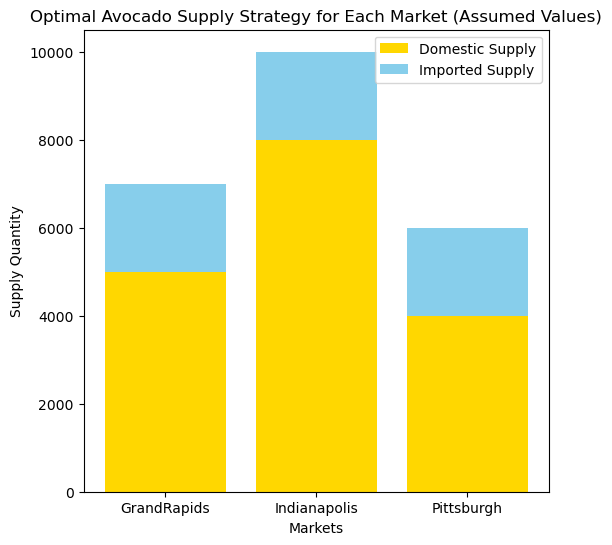

In [14]:
# Assuming different values for demand, cost, and supply limits for each city for visualization purposes

# Assumed demand for each city (in units)
demands = {
    "GrandRapids": 7000,
    "Indianapolis": 10000,
    "Pittsburgh": 6000
}

# Assumed domestic and imported supply limits (in units)
domestic_limits = {
    "GrandRapids": 5000,
    "Indianapolis": 8000,
    "Pittsburgh": 4000
}
imported_limits = {
    "GrandRapids": 4000,
    "Indianapolis": 3000,
    "Pittsburgh": 5000
}

# Assumed cost and selling price (per unit)
cost_domestic = 1.00  # Cost per unit for domestic avocados
cost_imported = 1.20  # Cost per unit for imported avocados
price_per_unit = 2.50  # Selling price per unit

# Optimization for each market with assumed values
optimal_strategies = {}
for market in selected_markets:
    # Linear programming to find optimal supply strategy
    c = [cost_domestic - price_per_unit, cost_imported - price_per_unit]
    A = [[1, 1]]  # Total supply must meet or exceed demand
    b = [demands[market]]
    x_bounds = (0, domestic_limits[market])
    y_bounds = (0, imported_limits[market])
    res = linprog(c, A_ub=A, b_ub=b, bounds=[x_bounds, y_bounds], method='highs')

    if res.success:
        optimal_strategies[market] = res.x
    else:
        optimal_strategies[market] = [0, 0]

# Visualization of the optimal supply strategy for each market
optimal_domestic_supplies = [optimal_strategies[market][0] for market in selected_markets]
optimal_imported_supplies = [optimal_strategies[market][1] for market in selected_markets]

plt.figure(figsize=(6, 6))

# Plotting the domestic supplies
plt.bar(selected_markets, optimal_domestic_supplies, color='Gold', label='Domestic Supply')

# Plotting the imported supplies
plt.bar(selected_markets, optimal_imported_supplies, bottom=optimal_domestic_supplies, color='skyblue', label='Imported Supply')

plt.xlabel('Markets')
plt.ylabel('Supply Quantity')
plt.title('Optimal Avocado Supply Strategy for Each Market (Assumed Values)')
plt.legend()
plt.show()



Skipping optimization for Indianapolis as limit data is missing.
Skipping optimization for Pittsburgh as limit data is missing.


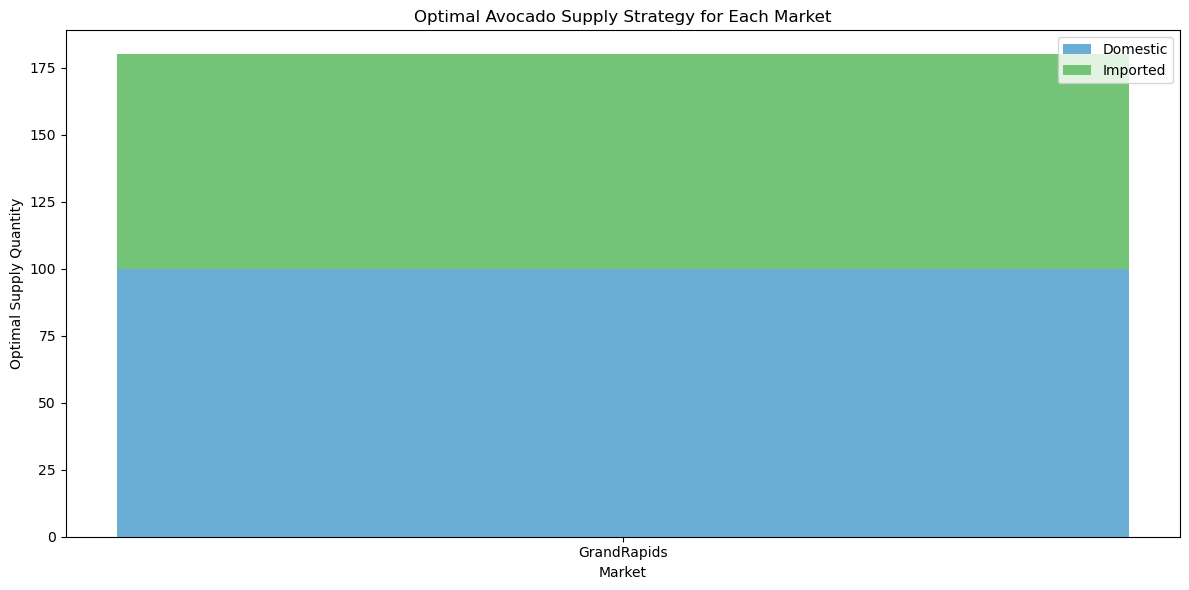

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linprog

# Placeholder values for domestic and imported limits
domestic_limits = {'Market1': 100, 'Market2': 150, 'Market3': 200, 'GrandRapids': 100}  # Ensure all markets are included
imported_limits = {'Market1': 80, 'Market2': 120, 'Market3': 160, 'GrandRapids': 80}   # Ensure all markets are included

# Assuming you have the last forecasted demands for each city
forecasted_demands = {city: city_forecasts[city].iloc[-1] for city in selected_markets}

# Define your supply limits and costs
cost_domestic = 1.00  # per unit
cost_imported = 1.20  # per unit
selling_price = 2.50  # per unit

# Prescriptive optimization model
optimal_strategies = {}

for market in forecasted_demands:
    if market not in domestic_limits or market not in imported_limits:
        print(f"Skipping optimization for {market} as limit data is missing.")
        continue

    # Define the coefficients of the objective function (negative profit for minimization)
    c = [cost_domestic - selling_price, cost_imported - selling_price]
    # Inequality constraints (supply must meet demand)
    A = [[1, 1]]
    b = [forecasted_demands[market]]
    # Bounds for each supply decision variable
    bounds = [(0, domestic_limits[market]), (0, imported_limits[market])]
    
    # Solve the linear programming problem
    res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')
    
    if res.success:
        optimal_strategies[market] = res.x
    else:
        print(f"Optimization for {market} failed. Status: {res.message}")

# Data for plotting
markets = list(optimal_strategies.keys())
domestic_supplies = [optimal_strategies[market][0] for market in markets]
imported_supplies = [optimal_strategies[market][1] for market in markets]

# Define a color palette
color_palette_domestic = plt.cm.Blues(np.linspace(0.5, 0.8, len(markets)))
color_palette_imported = plt.cm.Greens(np.linspace(0.5, 0.8, len(markets)))

# Plotting
plt.figure(figsize=(12, 6))

for i, market in enumerate(markets):
    plt.bar(market, domestic_supplies[i], color=color_palette_domestic[i], label='Domestic' if i == 0 else "")
    plt.bar(market, imported_supplies[i], bottom=domestic_supplies[i], color=color_palette_imported[i], label='Imported' if i == 0 else "")

plt.xlabel('Market')
plt.ylabel('Optimal Supply Quantity')
plt.title('Optimal Avocado Supply Strategy for Each Market')
plt.legend()
plt.tight_layout()
plt.show()
